<a href="https://www.kaggle.com/code/darvack/transformer-paper-regression2?scriptVersionId=136824720" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import random
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import cross_val_score
random.seed(42)
np.random.seed(42)

/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.5
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


Here, we have loaded the data and set Furan as the label.
At first, we have used KFold Round-Robin for testing our model so that every data points gets tested 1 time.

In [2]:
ds_A = pd.read_csv("/kaggle/input/transformer/DatasetA.csv").sample(frac=1, random_state=42).reset_index(drop=True)
ds_B = pd.read_csv("/kaggle/input/transformer/DatasetB.csv").sample(frac=1, random_state=42).reset_index(drop=True)


y_A = ds_A['Furan']
X_A = ds_A.drop(["Furan", "HI"], axis=1)

y_B = ds_B['Furan']
X_B = ds_B.drop(["Furan", "HI"], axis=1)

y_stratify = pd.DataFrame(y_A.copy())
bins = [-1, 0.1, 1, 100]
labels = [0, 1, 2]
y_stratify['Class'] = pd.cut(y_stratify['Furan'], bins=bins, labels=labels)
y_stratify = y_stratify.drop(["Furan"], axis=1)

In [3]:
#ds_A.hist(bins=50, figsize=(20,15))

The code below, drops the columns that we don't need, and only keeps the common features between dataset A and B.

In [4]:
X_A = X_A.drop(set(ds_A.columns) - set(ds_B.columns), axis=1)
X_B = X_B[X_A.columns]
X_A

,H2,Methane,Acetylene,Ethylene,Ethane,Water,Acid,BDV,IFT
0,22.6,0.0,0.0,0.5,0.7,6,0.005,51.0,30
1,8.9,5.1,2.7,2.9,3.3,24,0.019,36.0,26
2,13.4,14.8,0.0,1.4,2.2,3,0.005,77.0,31
3,18.5,12.4,0.0,0.9,3.2,8,0.005,51.0,32
4,19.9,31.0,0.0,2.1,26.8,3,0.005,80.0,32
...,...,...,...,...,...,...,...,...,...
725,13.9,2.1,0.0,1.1,2.1,6,0.026,73.0,27
726,42.5,4.7,0.0,1.0,2.0,3,0.005,68.0,37
727,12.7,12.7,0.0,0.3,1.2,5,0.005,81.0,36
728,10.3,0.5,0.0,0.0,0.0,5,0.005,51.0,35


The code below performs feature selection via step-wise regression or SequentialFeatureSelector. "n_features_to_select" is a hyperparameter that defines how many feature we'd like to keep which needs to be fine tuned. In our experiment, 6 or 7 features to keep, results in better models.

In [5]:
'''from sklearn.feature_selection import SequentialFeatureSelector
from catboost import CatBoostRegressor
from xgboost import XGBRegressor
from sklearn.ensemble import RandomForestRegressor

for i in range(1,9):
    rf_reg = RandomForestRegressor(min_samples_split=12, min_samples_leaf=1, random_state=42)
    
    xgb_reg = XGBRegressor(learning_rate=0.01, n_estimators=300, max_depth=3, subsample=0.7)

    sfs = SequentialFeatureSelector(rf_reg,
                                    n_features_to_select=i,
                                    direction='backward',
                                    scoring='neg_mean_squared_error',
                                    cv=4)

    sfs.fit(X_A, y_A)

    # Print the selected features
    print("Selected features" + f"{i}:", sfs.get_feature_names_out())
'''

useful_features1 = ['IFT']
useful_features2 = ['Methane', 'IFT']
useful_features3 = ['Methane', 'Ethane', 'IFT']
useful_features4 = ['Methane', 'Ethane', 'Water', 'IFT']
useful_features5 = ['Methane', 'Ethylene', 'Ethane', 'BDV', 'IFT']
useful_features6 = ['Methane', 'Ethylene', 'Ethane', 'Water', 'BDV', 'IFT']
useful_features7 = ['H2', 'Methane', 'Acetylene', 'Ethylene', 'Ethane', 'BDV', 'IFT']
useful_features8 = ['H2', 'Methane', 'Ethylene', 'Ethane', 'Water', 'Acid', 'BDV', 'IFT']

In [6]:
Selectedfeatures5 = ['H2', 'Ethane', 'Water', 'Acid', 'IFT']
Selectedfeatures6 = ['H2', 'Ethane', 'Water', 'Acid', 'BDV', 'IFT']
Selectedfeatures7 = ['H2', 'Acetylene', 'Ethane', 'Water', 'Acid', 'BDV', 'IFT']
Selectedfeatures8 = ['H2', 'Acetylene', 'Ethylene', 'Ethane', 'Water', 'Acid', 'BDV', 'IFT']

# Removing outliers

In [7]:
# For Dataset A
means = X_A.mean()
stds = X_A.std()

# Identify outliers 
outliers_A = X_A[(np.abs(X_A - means) > 3 * stds).any(axis=1)]

# Remove outliers 
X_A = X_A[~X_A.index.isin(outliers_A.index)]
y_A = y_A[~y_A.index.isin(outliers_A.index)]


# For Dataset B:
means = X_B.mean()
stds = X_B.std()

# Identify outliers 
outliers_B = X_B[(np.abs(X_B - means) > 3 * stds).any(axis=1)]

# Remove outliers 
X_B = X_B[~X_B.index.isin(outliers_B.index)]
y_B = y_B[~y_B.index.isin(outliers_B.index)]

# Standard Scaling

In [8]:
X_A = (X_A - X_A.mean())/X_A.std()
X_B = (X_B - X_B.mean())/X_B.std()

# Correlation Matrix and Mutual Information

<Axes: >

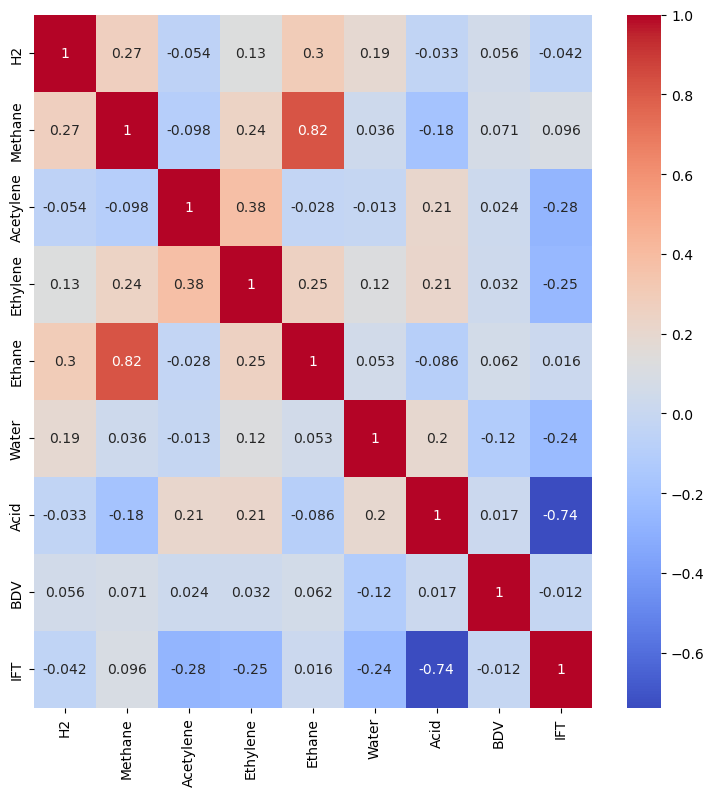

In [9]:
corr_matrix = X_A.corr()
import seaborn as sns
plt.figure(figsize=(9, 9))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm')

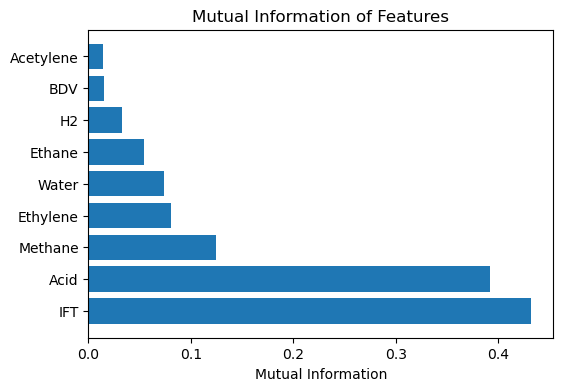

In [10]:
from sklearn.feature_selection import mutual_info_regression

# Compute the mutual information between all pairs of columns
mi_matrix = mutual_info_regression(X_A, y_A, random_state=0)

# Convert the mutual information scores to a DataFrame
mi_df = pd.DataFrame(mi_matrix, index=X_A.columns, columns=['Mutual Information'])

# Sort the DataFrame by mutual information score in descending order
mi_df = mi_df.sort_values(by=['Mutual Information'], ascending=False)

# Plot the mutual information scores as a horizontal bar chart
plt.figure(figsize=(6, 4))
plt.barh(mi_df.index, mi_df['Mutual Information'])
plt.xlabel('Mutual Information')
plt.title('Mutual Information of Features')
plt.show()

# First case: Training using 75% of the data and testing on the remaining 25% with Round-Robin (KFold)

Importing libraries

In [11]:
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor
from sklearn.ensemble import AdaBoostRegressor
from catboost import CatBoostRegressor
import lightgbm as lgb
from sklearn.linear_model import RidgeCV, LassoCV, ElasticNetCV, Ridge, Lasso, ElasticNet
from sklearn.ensemble import StackingRegressor
from sklearn.linear_model import BayesianRidge
from sklearn.linear_model import ARDRegression
from sklearn.model_selection import StratifiedShuffleSplit
from sklearn.neighbors import KNeighborsRegressor

Here is a comparison of different models.

**Random forest model**

In [12]:
from sklearn.metrics import mean_squared_error
reg = RandomForestRegressor(min_samples_split=12, min_samples_leaf=1, random_state=42)
scoring='neg_mean_squared_error'

scores = cross_val_score(reg, X_A, y_A, cv=4, scoring=scoring)
mse_scores = -scores
print(reg.__class__.__name__ + " for dataset A:")
print("MSE Scores:", mse_scores)
print("Mean MSE:", mse_scores.mean())

scores = cross_val_score(reg, X_A[Selectedfeatures7], y_A, cv=4, scoring=scoring)
mse_scores = -scores
print(reg.__class__.__name__ + " for dataset A with feature selection:")
print("MSE Scores:", mse_scores)
print("Mean MSE:", mse_scores.mean())

reg.fit(X_A, y_A)
y_pred_B = reg.predict(X_B)
print("MSE Score for dataset B:", mean_squared_error(y_B, y_pred_B))

reg.fit(X_A[useful_features6], y_A)
y_pred_B = reg.predict(X_B[useful_features6])
print("MSE Score for dataset B with feature selection:", mean_squared_error(y_B, y_pred_B))

RandomForestRegressor for dataset A:
MSE Scores: [0.57398357 0.17878687 0.17469908 0.27275149]
Mean MSE: 0.30005525157362456
RandomForestRegressor for dataset A with feature selection:
MSE Scores: [0.57510367 0.17856504 0.15801583 0.27847814]
Mean MSE: 0.29754066992262085
MSE Score for dataset B: 0.7066290176942751
MSE Score for dataset B with feature selection: 0.6208493165812511


In [13]:
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
reg = RandomForestRegressor(min_samples_split=12, min_samples_leaf=1, random_state=42)
scoring = 'neg_mean_squared_error'

scores = cross_val_score(reg, X_A, y_A, cv=4, scoring=scoring)
mse_scores = -scores
r2_scores = cross_val_score(reg, X_A, y_A, cv=4)
mae_scores = cross_val_score(reg, X_A, y_A, cv=4, scoring='neg_mean_absolute_error')
print(reg.__class__.__name__ + " for dataset A:")
print("MSE Scores:", mse_scores)
print("Mean MSE:", mse_scores.mean())
print("R2 Scores:", r2_scores)
print("Mean R2:", r2_scores.mean())
print("MAE Scores:", -mae_scores)
print("Mean MAE:", -mae_scores.mean(),"\n")

scores = cross_val_score(reg, X_A[Selectedfeatures7], y_A, cv=4, scoring=scoring)
mse_scores = -scores
r2_scores = cross_val_score(reg, X_A[Selectedfeatures7], y_A, cv=4)
mae_scores = cross_val_score(reg, X_A[Selectedfeatures7], y_A, cv=4, scoring='neg_mean_absolute_error')
print(reg.__class__.__name__ + " for dataset A with feature selection:")
print("MSE Scores:", mse_scores)
print("Mean MSE:", mse_scores.mean())
print("R2 Scores:", r2_scores)
print("Mean R2:", r2_scores.mean())
print("MAE Scores:", -mae_scores)
print("Mean MAE:", -mae_scores.mean(),"\n")

reg.fit(X_A, y_A)
y_pred_B = reg.predict(X_B)
mse_score = mean_squared_error(y_B, y_pred_B)
r2_score_1 = r2_score(y_B, y_pred_B)
mae_score = mean_absolute_error(y_B, y_pred_B)
print("MSE Score for dataset B without feature selection:", mse_score)
print("R2 Score for dataset B without feature selection:", r2_score_1)
print("MAE Score for dataset B without feature selection:", mae_score,"\n")

reg.fit(X_A[useful_features6], y_A)
y_pred_B = reg.predict(X_B[useful_features6])
mse_score = mean_squared_error(y_B, y_pred_B)
r2_score_2 = r2_score(y_B, y_pred_B)
mae_score = mean_absolute_error(y_B, y_pred_B)
print("MSE Score for dataset B with feature selection:", mse_score)
print("R2 Score for dataset B with feature selection:", r2_score_2)
print("MAE Score for dataset B with feature selection:", mae_score)

RandomForestRegressor for dataset A:
MSE Scores: [0.57398357 0.17878687 0.17469908 0.27275149]
Mean MSE: 0.30005525157362456
R2 Scores: [0.55836484 0.56562067 0.61206736 0.4336929 ]
Mean R2: 0.5424364392672665
MAE Scores: [0.30778532 0.16866834 0.1672423  0.20045014]
Mean MAE: 0.2110365261050937 

RandomForestRegressor for dataset A with feature selection:
MSE Scores: [0.57510367 0.17856504 0.15801583 0.27847814]
Mean MSE: 0.29754066992262085
R2 Scores: [0.557503   0.56615964 0.6491138  0.42180278]
Mean R2: 0.5486448051071289
MAE Scores: [0.30845496 0.17332536 0.16287032 0.19912098]
Mean MAE: 0.21094290491350062 

MSE Score for dataset B without feature selection: 0.7066290176942751
R2 Score for dataset B without feature selection: 0.04534639142279906
MAE Score for dataset B without feature selection: 0.335707371226802 

MSE Score for dataset B with feature selection: 0.6208493165812511
R2 Score for dataset B with feature selection: 0.16123450125082206
MAE Score for dataset B with feat

**Extra Tree Regressor**

In [14]:
from sklearn.ensemble import ExtraTreesRegressor

reg = ExtraTreesRegressor()

scores = cross_val_score(reg, X_A, y_A, cv=4, scoring=scoring)
mse_scores = -scores
r2_scores = cross_val_score(reg, X_A, y_A, cv=4)
mae_scores = cross_val_score(reg, X_A, y_A, cv=4, scoring='neg_mean_absolute_error')
print(reg.__class__.__name__ + " for dataset A:")
print("MSE Scores:", mse_scores)
print("Mean MSE:", mse_scores.mean())
print("R2 Scores:", r2_scores)
print("Mean R2:", r2_scores.mean())
print("MAE Scores:", -mae_scores)
print("Mean MAE:", -mae_scores.mean(),"\n")

scores = cross_val_score(reg, X_A[Selectedfeatures7], y_A, cv=4, scoring=scoring)
mse_scores = -scores
r2_scores = cross_val_score(reg, X_A[Selectedfeatures7], y_A, cv=4)
mae_scores = cross_val_score(reg, X_A[Selectedfeatures7], y_A, cv=4, scoring='neg_mean_absolute_error')
print(reg.__class__.__name__ + " for dataset A with feature selection:")
print("MSE Scores:", mse_scores)
print("Mean MSE:", mse_scores.mean())
print("R2 Scores:", r2_scores)
print("Mean R2:", r2_scores.mean())
print("MAE Scores:", -mae_scores)
print("Mean MAE:", -mae_scores.mean(),"\n")

reg.fit(X_A, y_A)
y_pred_B = reg.predict(X_B)
mse_score = mean_squared_error(y_B, y_pred_B)
r2_score_1 = r2_score(y_B, y_pred_B)
mae_score = mean_absolute_error(y_B, y_pred_B)
print("MSE Score for dataset B without feature selection:", mse_score)
print("R2 Score for dataset B without feature selection:", r2_score_1)
print("MAE Score for dataset B without feature selection:", mae_score,"\n")

reg.fit(X_A[useful_features6], y_A)
y_pred_B = reg.predict(X_B[useful_features6])
mse_score = mean_squared_error(y_B, y_pred_B)
r2_score_2 = r2_score(y_B, y_pred_B)
mae_score = mean_absolute_error(y_B, y_pred_B)
print("MSE Score for dataset B with feature selection:", mse_score)
print("R2 Score for dataset B with feature selection:", r2_score_2)
print("MAE Score for dataset B with feature selection:", mae_score)

ExtraTreesRegressor for dataset A:
MSE Scores: [0.51405558 0.15505411 0.211506   0.24277483]
Mean MSE: 0.28084763204188595
R2 Scores: [0.59612316 0.63802996 0.57377468 0.53616763]
Mean R2: 0.5860238561810885
MAE Scores: [0.29108375 0.17270994 0.18422466 0.18289782]
Mean MAE: 0.20772904192132197 

ExtraTreesRegressor for dataset A with feature selection:
MSE Scores: [0.49427243 0.16618726 0.17281564 0.26358746]
Mean MSE: 0.27421569923781797
R2 Scores: [0.62579333 0.61122774 0.61183253 0.53175041]
Mean R2: 0.5951510030346514
MAE Scores: [0.29209236 0.16922165 0.17598708 0.18366779]
Mean MAE: 0.20524222034711156 

MSE Score for dataset B without feature selection: 0.6788453301029457
R2 Score for dataset B without feature selection: 0.08288206708071533
MAE Score for dataset B without feature selection: 0.3440537128868687 

MSE Score for dataset B with feature selection: 0.6973192625528842
R2 Score for dataset B with feature selection: 0.057923841708805046
MAE Score for dataset B with featu

In [15]:
from sklearn.ensemble import ExtraTreesRegressor

reg = ExtraTreesRegressor(min_samples_split = 5)

scores = cross_val_score(reg, X_A, y_A, cv=4, scoring=scoring)
mse_scores = -scores
r2_scores = cross_val_score(reg, X_A, y_A, cv=4)
mae_scores = cross_val_score(reg, X_A, y_A, cv=4, scoring='neg_mean_absolute_error')
print(reg.__class__.__name__ + " for dataset A:")
print("MSE Scores:", mse_scores)
print("Mean MSE:", mse_scores.mean())
print("R2 Scores:", r2_scores)
print("Mean R2:", r2_scores.mean())
print("MAE Scores:", -mae_scores)
print("Mean MAE:", -mae_scores.mean(),"\n")

scores = cross_val_score(reg, X_A[Selectedfeatures7], y_A, cv=4, scoring=scoring)
mse_scores = -scores
r2_scores = cross_val_score(reg, X_A[Selectedfeatures7], y_A, cv=4)
mae_scores = cross_val_score(reg, X_A[Selectedfeatures7], y_A, cv=4, scoring='neg_mean_absolute_error')
print(reg.__class__.__name__ + " for dataset A with feature selection:")
print("MSE Scores:", mse_scores)
print("Mean MSE:", mse_scores.mean())
print("R2 Scores:", r2_scores)
print("Mean R2:", r2_scores.mean())
print("MAE Scores:", -mae_scores)
print("Mean MAE:", -mae_scores.mean(),"\n")

reg.fit(X_A, y_A)
y_pred_B = reg.predict(X_B)
mse_score = mean_squared_error(y_B, y_pred_B)
r2_score_1 = r2_score(y_B, y_pred_B)
mae_score = mean_absolute_error(y_B, y_pred_B)
print("MSE Score for dataset B without feature selection:", mse_score)
print("R2 Score for dataset B without feature selection:", r2_score_1)
print("MAE Score for dataset B without feature selection:", mae_score,"\n")

reg.fit(X_A[useful_features6], y_A)
y_pred_B = reg.predict(X_B[useful_features6])
mse_score = mean_squared_error(y_B, y_pred_B)
r2_score_2 = r2_score(y_B, y_pred_B)
mae_score = mean_absolute_error(y_B, y_pred_B)
print("MSE Score for dataset B with feature selection:", mse_score)
print("R2 Score for dataset B with feature selection:", r2_score_2)
print("MAE Score for dataset B with feature selection:", mae_score)

ExtraTreesRegressor for dataset A:
MSE Scores: [0.51680384 0.15149896 0.19183092 0.22938735]
Mean MSE: 0.2723802664648978
R2 Scores: [0.57859362 0.62516106 0.54848284 0.52551015]
Mean R2: 0.5694369161266553
MAE Scores: [0.29124528 0.17024643 0.1807512  0.1816373 ]
Mean MAE: 0.20597005076495387 

ExtraTreesRegressor for dataset A with feature selection:
MSE Scores: [0.54698494 0.15352841 0.1701095  0.21456031]
Mean MSE: 0.2712957919278677
R2 Scores: [0.60851085 0.61433046 0.6118422  0.53354574]
Mean R2: 0.592057310903956
MAE Scores: [0.29348682 0.17070899 0.16619688 0.18636455]
Mean MAE: 0.20418931090500006 

MSE Score for dataset B without feature selection: 0.6904695470238253
R2 Score for dataset B without feature selection: 0.0671777861178251
MAE Score for dataset B without feature selection: 0.351258163708207 

MSE Score for dataset B with feature selection: 0.6659904162452434
R2 Score for dataset B with feature selection: 0.10024901578351264
MAE Score for dataset B with feature sel

**CatBoost Model:**

In [16]:
reg = CatBoostRegressor(verbose=0)

scores = cross_val_score(reg, X_A, y_A, cv=4, scoring=scoring)
mse_scores = -scores
r2_scores = cross_val_score(reg, X_A, y_A, cv=4)
mae_scores = cross_val_score(reg, X_A, y_A, cv=4, scoring='neg_mean_absolute_error')
print(reg.__class__.__name__ + " for dataset A:")
print("MSE Scores:", mse_scores)
print("Mean MSE:", mse_scores.mean())
print("R2 Scores:", r2_scores)
print("Mean R2:", r2_scores.mean())
print("MAE Scores:", -mae_scores)
print("Mean MAE:", -mae_scores.mean(),"\n")

scores = cross_val_score(reg, X_A[Selectedfeatures7], y_A, cv=4, scoring=scoring)
mse_scores = -scores
r2_scores = cross_val_score(reg, X_A[Selectedfeatures7], y_A, cv=4)
mae_scores = cross_val_score(reg, X_A[Selectedfeatures7], y_A, cv=4, scoring='neg_mean_absolute_error')
print(reg.__class__.__name__ + " for dataset A with feature selection:")
print("MSE Scores:", mse_scores)
print("Mean MSE:", mse_scores.mean())
print("R2 Scores:", r2_scores)
print("Mean R2:", r2_scores.mean())
print("MAE Scores:", -mae_scores)
print("Mean MAE:", -mae_scores.mean(),"\n")

reg.fit(X_A, y_A)
y_pred_B = reg.predict(X_B)
mse_score = mean_squared_error(y_B, y_pred_B)
r2_score_1 = r2_score(y_B, y_pred_B)
mae_score = mean_absolute_error(y_B, y_pred_B)
print("MSE Score for dataset B without feature selection:", mse_score)
print("R2 Score for dataset B without feature selection:", r2_score_1)
print("MAE Score for dataset B without feature selection:", mae_score,"\n")

reg.fit(X_A[useful_features6], y_A)
y_pred_B = reg.predict(X_B[useful_features6])
mse_score = mean_squared_error(y_B, y_pred_B)
r2_score_2 = r2_score(y_B, y_pred_B)
mae_score = mean_absolute_error(y_B, y_pred_B)
print("MSE Score for dataset B with feature selection:", mse_score)
print("R2 Score for dataset B with feature selection:", r2_score_2)
print("MAE Score for dataset B with feature selection:", mae_score)

CatBoostRegressor for dataset A:
MSE Scores: [0.60876535 0.20727773 0.15943384 0.21784846]
Mean MSE: 0.2983313434688387
R2 Scores: [0.53160299 0.49639949 0.64596499 0.54768668]
Mean R2: 0.55541353811114
MAE Scores: [0.30870278 0.18663192 0.172928   0.19679759]
Mean MAE: 0.21626507401716646 

CatBoostRegressor for dataset A with feature selection:
MSE Scores: [0.57981618 0.16536101 0.14090203 0.20520028]
Mean MSE: 0.27281987290043996
R2 Scores: [0.5538771  0.59824005 0.6871163  0.57394779]
Mean R2: 0.6032953071249831
MAE Scores: [0.29836723 0.16977154 0.1683758  0.18235111]
Mean MAE: 0.20471642215383618 

MSE Score for dataset B without feature selection: 0.63162457160402
R2 Score for dataset B without feature selection: 0.14667716517595897
MAE Score for dataset B without feature selection: 0.3053874074138435 

MSE Score for dataset B with feature selection: 0.6984851920373661
R2 Score for dataset B with feature selection: 0.05634867459588477
MAE Score for dataset B with feature selecti

**XGB Model:**

In [17]:
reg = XGBRegressor(random_state=42, learning_rate=0.005, n_estimators=500, max_depth=5, subsample=0.95)

scores = cross_val_score(reg, X_A, y_A, cv=4, scoring=scoring)
mse_scores = -scores
r2_scores = cross_val_score(reg, X_A, y_A, cv=4)
mae_scores = cross_val_score(reg, X_A, y_A, cv=4, scoring='neg_mean_absolute_error')
print(reg.__class__.__name__ + " for dataset A:")
print("MSE Scores:", mse_scores)
print("Mean MSE:", mse_scores.mean())
print("R2 Scores:", r2_scores)
print("Mean R2:", r2_scores.mean())
print("MAE Scores:", -mae_scores)
print("Mean MAE:", -mae_scores.mean(),"\n")

scores = cross_val_score(reg, X_A[Selectedfeatures7], y_A, cv=4, scoring=scoring)
mse_scores = -scores
r2_scores = cross_val_score(reg, X_A[Selectedfeatures7], y_A, cv=4)
mae_scores = cross_val_score(reg, X_A[Selectedfeatures7], y_A, cv=4, scoring='neg_mean_absolute_error')
print(reg.__class__.__name__ + " for dataset A with feature selection:")
print("MSE Scores:", mse_scores)
print("Mean MSE:", mse_scores.mean())
print("R2 Scores:", r2_scores)
print("Mean R2:", r2_scores.mean())
print("MAE Scores:", -mae_scores)
print("Mean MAE:", -mae_scores.mean(),"\n")

reg.fit(X_A, y_A)
y_pred_B = reg.predict(X_B)
mse_score = mean_squared_error(y_B, y_pred_B)
r2_score_1 = r2_score(y_B, y_pred_B)
mae_score = mean_absolute_error(y_B, y_pred_B)
print("MSE Score for dataset B without feature selection:", mse_score)
print("R2 Score for dataset B without feature selection:", r2_score_1)
print("MAE Score for dataset B without feature selection:", mae_score,"\n")

reg.fit(X_A[useful_features6], y_A)
y_pred_B = reg.predict(X_B[useful_features6])
mse_score = mean_squared_error(y_B, y_pred_B)
r2_score_2 = r2_score(y_B, y_pred_B)
mae_score = mean_absolute_error(y_B, y_pred_B)
print("MSE Score for dataset B with feature selection:", mse_score)
print("R2 Score for dataset B with feature selection:", r2_score_2)
print("MAE Score for dataset B with feature selection:", mae_score)

XGBRegressor for dataset A:
MSE Scores: [0.69801285 0.21884762 0.14497202 0.19002685]
Mean MSE: 0.3129648344351783
R2 Scores: [0.46293407 0.46828937 0.67807855 0.605452  ]
Mean R2: 0.5536884960855355
MAE Scores: [0.33623298 0.21021271 0.17673859 0.1940567 ]
Mean MAE: 0.22931024647391532 

XGBRegressor for dataset A with feature selection:
MSE Scores: [0.66608761 0.21200202 0.13734361 0.1979325 ]
Mean MSE: 0.3033414346555336
R2 Scores: [0.48749803 0.48492137 0.69501803 0.58903769]
Mean R2: 0.5641187808012338
MAE Scores: [0.32993889 0.20976646 0.17942276 0.19814066]
Mean MAE: 0.22931719190008226 

MSE Score for dataset B without feature selection: 0.5718469275673665
R2 Score for dataset B without feature selection: 0.22743657663919548
MAE Score for dataset B without feature selection: 0.3141436978134041 

MSE Score for dataset B with feature selection: 0.6422054665667478
R2 Score for dataset B with feature selection: 0.13238240893865605
MAE Score for dataset B with feature selection: 0.3

**KNN Model:**

In [18]:
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
reg = KNeighborsRegressor(n_neighbors=5)
scoring = 'neg_mean_squared_error'

scores = cross_val_score(reg, X_A, y_A, cv=4, scoring=scoring)
mse_scores = -scores
r2_scores = cross_val_score(reg, X_A, y_A, cv=4)
mae_scores = cross_val_score(reg, X_A, y_A, cv=4, scoring='neg_mean_absolute_error')
print(reg.__class__.__name__ + " for dataset A:")
print("MSE Scores:", mse_scores)
print("Mean MSE:", mse_scores.mean())
print("R2 Scores:", r2_scores)
print("Mean R2:", r2_scores.mean())
print("MAE Scores:", -mae_scores)
print("Mean MAE:", -mae_scores.mean(),"\n")

scores = cross_val_score(reg, X_A[Selectedfeatures7], y_A, cv=4, scoring=scoring)
mse_scores = -scores
r2_scores = cross_val_score(reg, X_A[Selectedfeatures7], y_A, cv=4)
mae_scores = cross_val_score(reg, X_A[Selectedfeatures7], y_A, cv=4, scoring='neg_mean_absolute_error')
print(reg.__class__.__name__ + " for dataset A with feature selection:")
print("MSE Scores:", mse_scores)
print("Mean MSE:", mse_scores.mean())
print("R2 Scores:", r2_scores)
print("Mean R2:", r2_scores.mean())
print("MAE Scores:", -mae_scores)
print("Mean MAE:", -mae_scores.mean(),"\n")

reg.fit(X_A, y_A)
y_pred_B = reg.predict(X_B)
mse_score = mean_squared_error(y_B, y_pred_B)
r2_score_1 = r2_score(y_B, y_pred_B)
mae_score = mean_absolute_error(y_B, y_pred_B)
print("MSE Score for dataset B without feature selection:", mse_score)
print("R2 Score for dataset B without feature selection:", r2_score_1)
print("MAE Score for dataset B without feature selection:", mae_score,"\n")

reg.fit(X_A[useful_features6], y_A)
y_pred_B = reg.predict(X_B[useful_features6])
mse_score = mean_squared_error(y_B, y_pred_B)
r2_score_2 = r2_score(y_B, y_pred_B)
mae_score = mean_absolute_error(y_B, y_pred_B)
print("MSE Score for dataset B with feature selection:", mse_score)
print("R2 Score for dataset B with feature selection:", r2_score_2)
print("MAE Score for dataset B with feature selection:", mae_score)

KNeighborsRegressor for dataset A:
MSE Scores: [0.62995614 0.16496179 0.21238804 0.2275418 ]
Mean MSE: 0.30871194365115956
R2 Scores: [0.51529834 0.59921    0.52837614 0.52756064]
Mean R2: 0.5426112807093473
MAE Scores: [0.31579966 0.16298113 0.16567975 0.19351139]
Mean MAE: 0.2094929820664159 

KNeighborsRegressor for dataset A with feature selection:
MSE Scores: [0.63400546 0.16739758 0.16656141 0.2532884 ]
Mean MSE: 0.30531321192410366
R2 Scores: [0.51218272 0.593292   0.63013769 0.47410362]
Mean R2: 0.5524290050460751
MAE Scores: [0.3248311  0.16644025 0.14954304 0.18979678]
Mean MAE: 0.20765279273566 

MSE Score for dataset B without feature selection: 0.7348768593711329
R2 Score for dataset B without feature selection: 0.00718364503669322
MAE Score for dataset B without feature selection: 0.3097087235993266 

MSE Score for dataset B with feature selection: 0.6517713654013012
R2 Score for dataset B with feature selection: 0.11945890931860237
MAE Score for dataset B with feature se

**Bayesian Ridge**

In [19]:
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
reg = BayesianRidge()
scoring = 'neg_mean_squared_error'

scores = cross_val_score(reg, X_A, y_A, cv=4, scoring=scoring)
mse_scores = -scores
r2_scores = cross_val_score(reg, X_A, y_A, cv=4)
mae_scores = cross_val_score(reg, X_A, y_A, cv=4, scoring='neg_mean_absolute_error')
print(reg.__class__.__name__ + " for dataset A:")
print("MSE Scores:", mse_scores)
print("Mean MSE:", mse_scores.mean())
print("R2 Scores:", r2_scores)
print("Mean R2:", r2_scores.mean())
print("MAE Scores:", -mae_scores)
print("Mean MAE:", -mae_scores.mean(),"\n")

scores = cross_val_score(reg, X_A[Selectedfeatures7], y_A, cv=4, scoring=scoring)
mse_scores = -scores
r2_scores = cross_val_score(reg, X_A[Selectedfeatures7], y_A, cv=4)
mae_scores = cross_val_score(reg, X_A[Selectedfeatures7], y_A, cv=4, scoring='neg_mean_absolute_error')
print(reg.__class__.__name__ + " for dataset A with feature selection:")
print("MSE Scores:", mse_scores)
print("Mean MSE:", mse_scores.mean())
print("R2 Scores:", r2_scores)
print("Mean R2:", r2_scores.mean())
print("MAE Scores:", -mae_scores)
print("Mean MAE:", -mae_scores.mean(),"\n")

reg.fit(X_A, y_A)
y_pred_B = reg.predict(X_B)
mse_score = mean_squared_error(y_B, y_pred_B)
r2_score_1 = r2_score(y_B, y_pred_B)
mae_score = mean_absolute_error(y_B, y_pred_B)
print("MSE Score for dataset B without feature selection:", mse_score)
print("R2 Score for dataset B without feature selection:", r2_score_1)
print("MAE Score for dataset B without feature selection:", mae_score,"\n")

reg.fit(X_A[useful_features6], y_A)
y_pred_B = reg.predict(X_B[useful_features6])
mse_score = mean_squared_error(y_B, y_pred_B)
r2_score_2 = r2_score(y_B, y_pred_B)
mae_score = mean_absolute_error(y_B, y_pred_B)
print("MSE Score for dataset B with feature selection:", mse_score)
print("R2 Score for dataset B with feature selection:", r2_score_2)
print("MAE Score for dataset B with feature selection:", mae_score)

BayesianRidge for dataset A:
MSE Scores: [0.5924582  0.17542306 0.25157645 0.27469477]
Mean MSE: 0.3235381172190944
R2 Scores: [0.54415006 0.57379337 0.4413553  0.42965812]
Mean R2: 0.49723921068111876
MAE Scores: [0.3871905  0.25568589 0.26546904 0.28443074]
Mean MAE: 0.2981940398779175 

BayesianRidge for dataset A with feature selection:
MSE Scores: [0.58822603 0.18378986 0.25532584 0.27411568]
Mean MSE: 0.32536435361799
R2 Scores: [0.54740638 0.55346545 0.43302948 0.43086045]
Mean R2: 0.491190439447746
MAE Scores: [0.38810518 0.26026615 0.27112389 0.27674225]
Mean MAE: 0.29905936777126724 

MSE Score for dataset B without feature selection: 0.5795212504372924
R2 Score for dataset B without feature selection: 0.21706859027335534
MAE Score for dataset B without feature selection: 0.34639373193701195 

MSE Score for dataset B with feature selection: 0.5954296859300872
R2 Score for dataset B with feature selection: 0.19557634332378993
MAE Score for dataset B with feature selection: 0.4

**AdaBoost**

In [20]:
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
reg = AdaBoostRegressor(random_state=42, n_estimators=200, learning_rate=0.003)
scoring = 'neg_mean_squared_error'

scores = cross_val_score(reg, X_A, y_A, cv=4, scoring=scoring)
mse_scores = -scores
r2_scores = cross_val_score(reg, X_A, y_A, cv=4)
mae_scores = cross_val_score(reg, X_A, y_A, cv=4, scoring='neg_mean_absolute_error')
print(reg.__class__.__name__ + " for dataset A:")
print("MSE Scores:", mse_scores)
print("Mean MSE:", mse_scores.mean())
print("R2 Scores:", r2_scores)
print("Mean R2:", r2_scores.mean())
print("MAE Scores:", -mae_scores)
print("Mean MAE:", -mae_scores.mean(),"\n")

scores = cross_val_score(reg, X_A[Selectedfeatures7], y_A, cv=4, scoring=scoring)
mse_scores = -scores
r2_scores = cross_val_score(reg, X_A[Selectedfeatures7], y_A, cv=4)
mae_scores = cross_val_score(reg, X_A[Selectedfeatures7], y_A, cv=4, scoring='neg_mean_absolute_error')
print(reg.__class__.__name__ + " for dataset A with feature selection:")
print("MSE Scores:", mse_scores)
print("Mean MSE:", mse_scores.mean())
print("R2 Scores:", r2_scores)
print("Mean R2:", r2_scores.mean())
print("MAE Scores:", -mae_scores)
print("Mean MAE:", -mae_scores.mean(),"\n")

reg.fit(X_A, y_A)
y_pred_B = reg.predict(X_B)
mse_score = mean_squared_error(y_B, y_pred_B)
r2_score_1 = r2_score(y_B, y_pred_B)
mae_score = mean_absolute_error(y_B, y_pred_B)
print("MSE Score for dataset B without feature selection:", mse_score)
print("R2 Score for dataset B without feature selection:", r2_score_1)
print("MAE Score for dataset B without feature selection:", mae_score,"\n")

reg.fit(X_A[useful_features6], y_A)
y_pred_B = reg.predict(X_B[useful_features6])
mse_score = mean_squared_error(y_B, y_pred_B)
r2_score_2 = r2_score(y_B, y_pred_B)
mae_score = mean_absolute_error(y_B, y_pred_B)
print("MSE Score for dataset B with feature selection:", mse_score)
print("R2 Score for dataset B with feature selection:", r2_score_2)
print("MAE Score for dataset B with feature selection:", mae_score)

AdaBoostRegressor for dataset A:
MSE Scores: [0.6765929  0.17044313 0.21250842 0.31193636]
Mean MSE: 0.3428702035330903
R2 Scores: [0.47941503 0.58589257 0.52810883 0.35233432]
Mean R2: 0.4864376872298079
MAE Scores: [0.32506704 0.16936081 0.18081843 0.21080414]
Mean MAE: 0.22151260437908324 

AdaBoostRegressor for dataset A with feature selection:
MSE Scores: [0.66881749 0.18725453 0.19510538 0.32278084]
Mean MSE: 0.3434895571618888
R2 Scores: [0.4853976  0.54504772 0.56675362 0.3298182 ]
Mean R2: 0.481754284290053
MAE Scores: [0.32582597 0.17633166 0.17380832 0.21233723]
Mean MAE: 0.2220757944749121 

MSE Score for dataset B without feature selection: 0.7706172118093417
R2 Score for dataset B without feature selection: -0.041101460121157896
MAE Score for dataset B without feature selection: 0.35438123736625854 

MSE Score for dataset B with feature selection: 0.5796439238266107
R2 Score for dataset B with feature selection: 0.21690285890532968
MAE Score for dataset B with feature sel

# Stacking Model:
This model consists of ridge regression, AdaBoost, Bayesian ARD regression and a random forest model. It takes the output of these models and stack their cross-validation to form the training set of a meta-model. The meta-model train on this new dataset and outputs the final prediction.

The features below are selected by step-wise regression.

In [21]:
Selectedfeatures1 = ['Acid']
Selectedfeatures2 = ['Water', 'Acid']
Selectedfeatures3 = ['Ethane', 'Water', 'Acid']
Selectedfeatures4 = ['Ethane', 'Water', 'Acid', 'IFT']
Selectedfeatures5 = ['Ethane', 'Water', 'Acid', 'BDV', 'IFT']
Selectedfeatures6 = ['Acetylene', 'Ethane', 'Water', 'Acid', 'BDV', 'IFT']
Selectedfeatures7 = ['H2', 'Acetylene', 'Ethane', 'Water', 'Acid', 'BDV', 'IFT']
Selectedfeatures8 = ['H2', 'Acetylene', 'Ethylene', 'Ethane', 'Water', 'Acid', 'BDV', 'IFT']

In [22]:
from sklearn.linear_model import RidgeCV, LassoCV, ElasticNetCV, Ridge, Lasso, ElasticNet
from sklearn.ensemble import StackingRegressor
from sklearn.linear_model import BayesianRidge
from sklearn.linear_model import ARDRegression
from sklearn.model_selection import StratifiedShuffleSplit
from sklearn.neighbors import KNeighborsRegressor

estimators = [('ridge', Ridge(alpha=1)),
              ('ada', AdaBoostRegressor(random_state=42, n_estimators=200, learning_rate=0.003)),
              ('adr', ARDRegression()),
              ('rf', RandomForestRegressor(min_samples_split=2, min_samples_leaf=1, random_state=41))
             ]

final_estimator = Ridge(alpha=0.01)

reg = StackingRegressor(
    estimators=estimators, final_estimator=final_estimator, cv=5)

# Testing dataset A without Feature selection
scores = cross_val_score(reg, X_A, y_A, cv=4, scoring=scoring)
mse_scores = -scores
print(reg.__class__.__name__ + " for dataset A:")
print("MSE Scores without feature selection:", mse_scores)
print("Mean MSE without feature selection:", mse_scores.mean())

# Testing dataset A with Feature selection
scores = cross_val_score(reg, X_A[Selectedfeatures7], y_A, cv=4, scoring=scoring)
mse_scores = -scores
print(reg.__class__.__name__ + " for dataset A:")
print("MSE Scores with feature selection:", mse_scores)
print("Mean MSE with feature selection:", mse_scores.mean())

# Testing dataset B without Feature Selection
reg.fit(X_A, y_A)
y_pred_B = reg.predict(X_B)
print(reg.__class__.__name__ + " for dataset B without feature selection:", mean_squared_error(y_B, y_pred_B))

# Testing dataset B with Feature selection
reg.fit(X_A[useful_features6], y_A)
y_pred_B = reg.predict(X_B[useful_features6])
print(reg.__class__.__name__ + " for dataset B with feature selection:", mean_squared_error(y_B, y_pred_B))

StackingRegressor for dataset A:
MSE Scores without feature selection: [0.55815109 0.21156398 0.19706352 0.2484599 ]
Mean MSE without feature selection: 0.303809624137932
StackingRegressor for dataset A:
MSE Scores with feature selection: [0.52819748 0.18085488 0.19024146 0.26186562]
Mean MSE with feature selection: 0.29028985931374784
StackingRegressor for dataset B without feature selection: 0.7042847014168399
StackingRegressor for dataset B with feature selection: 0.582263012846314


In [23]:
# TESTTTTTTTTTTTTTTTTTTTTT

from sklearn.linear_model import RidgeCV, LassoCV, ElasticNetCV, Ridge, Lasso, ElasticNet
from sklearn.ensemble import StackingRegressor
from sklearn.linear_model import BayesianRidge
from sklearn.linear_model import ARDRegression
from sklearn.model_selection import StratifiedShuffleSplit

estimators = [#('ridge', Ridge(alpha=1)),
              ('ada', AdaBoostRegressor(random_state=42, n_estimators=200, learning_rate=0.003)),
              ('bay', BayesianRidge()),
              ('knn', KNeighborsRegressor(n_neighbors=5)),
              ('rf', RandomForestRegressor(min_samples_split=2, min_samples_leaf=1, random_state=41))
             ]

final_estimator = Ridge(alpha=1)

reg = StackingRegressor(
    estimators=estimators, final_estimator=final_estimator, cv=5)

# Testing dataset A without Feature selection
scores = cross_val_score(reg, X_A, y_A, cv=4, scoring=scoring)
mse_scores = -scores
print(reg.__class__.__name__ + " for dataset A:")
print("MSE Scores without feature selection:", mse_scores)
print("Mean MSE without feature selection:", mse_scores.mean())

# Testing dataset A with Feature selection
scores = cross_val_score(reg, X_A[Selectedfeatures7], y_A, cv=4, scoring=scoring)
mse_scores = -scores
print(reg.__class__.__name__ + " for dataset A:")
print("MSE Scores with feature selection:", mse_scores)
print("Mean MSE with feature selection:", mse_scores.mean())

# Testing dataset B without Feature Selection
reg.fit(X_A, y_A)
y_pred_B = reg.predict(X_B)
print(reg.__class__.__name__ + " for dataset B without feature selection:", mean_squared_error(y_B, y_pred_B))

# Testing dataset B with Feature selection
reg.fit(X_A[useful_features6], y_A)
y_pred_B = reg.predict(X_B[useful_features6])
print(reg.__class__.__name__ + " for dataset B with feature selection:", mean_squared_error(y_B, y_pred_B))

StackingRegressor for dataset A:
MSE Scores without feature selection: [0.54263576 0.17510746 0.18766018 0.22879703]
Mean MSE without feature selection: 0.2835501059841291
StackingRegressor for dataset A:
MSE Scores with feature selection: [0.52697107 0.15495942 0.16477605 0.24966393]
Mean MSE with feature selection: 0.2740926156054783
StackingRegressor for dataset B without feature selection: 0.7124389098497912
StackingRegressor for dataset B with feature selection: 0.5857375954044269


**Final Stacking Model for All Metrics**

In [24]:
from sklearn.linear_model import RidgeCV, LassoCV, ElasticNetCV, Ridge, Lasso, ElasticNet, LinearRegression
from sklearn.ensemble import StackingRegressor
from sklearn.linear_model import BayesianRidge
from sklearn.linear_model import ARDRegression
from sklearn.model_selection import StratifiedShuffleSplit

estimators = [#('ridge', Ridge(alpha=1)),
              ('ada', AdaBoostRegressor(random_state=42, n_estimators=200, learning_rate=0.003)),
              ('bay', BayesianRidge()),
              ('knn', KNeighborsRegressor(n_neighbors=5)),
              ('rf', RandomForestRegressor(min_samples_split=2, min_samples_leaf=1, random_state=41))
             ]

final_estimator = LinearRegression()

reg = StackingRegressor(
    estimators=estimators, final_estimator=final_estimator, cv=5)

scores = cross_val_score(reg, X_A, y_A, cv=4, scoring=scoring)
mse_scores = -scores
r2_scores = cross_val_score(reg, X_A, y_A, cv=4)
mae_scores = cross_val_score(reg, X_A, y_A, cv=4, scoring='neg_mean_absolute_error')
print(reg.__class__.__name__ + " for dataset A:")
print("MSE Scores:", mse_scores)
print("Mean MSE:", mse_scores.mean())
print("R2 Scores:", r2_scores)
print("Mean R2:", r2_scores.mean())
print("MAE Scores:", -mae_scores)
print("Mean MAE:", -mae_scores.mean(),"\n")

scores = cross_val_score(reg, X_A[Selectedfeatures7], y_A, cv=4, scoring=scoring)
mse_scores = -scores
r2_scores = cross_val_score(reg, X_A[Selectedfeatures7], y_A, cv=4)
mae_scores = cross_val_score(reg, X_A[Selectedfeatures7], y_A, cv=4, scoring='neg_mean_absolute_error')
print(reg.__class__.__name__ + " for dataset A with feature selection:")
print("MSE Scores:", mse_scores)
print("Mean MSE:", mse_scores.mean())
print("R2 Scores:", r2_scores)
print("Mean R2:", r2_scores.mean())
print("MAE Scores:", -mae_scores)
print("Mean MAE:", -mae_scores.mean(),"\n")

reg.fit(X_A, y_A)
y_pred_B = reg.predict(X_B)
mse_score = mean_squared_error(y_B, y_pred_B)
r2_score_1 = r2_score(y_B, y_pred_B)
mae_score = mean_absolute_error(y_B, y_pred_B)
print("MSE Score for dataset B without feature selection:", mse_score)
print("R2 Score for dataset B without feature selection:", r2_score_1)
print("MAE Score for dataset B without feature selection:", mae_score,"\n")

reg.fit(X_A[useful_features6], y_A)
y_pred_B = reg.predict(X_B[useful_features6])
mse_score = mean_squared_error(y_B, y_pred_B)
r2_score_2 = r2_score(y_B, y_pred_B)
mae_score = mean_absolute_error(y_B, y_pred_B)
print("MSE Score for dataset B with feature selection:", mse_score)
print("R2 Score for dataset B with feature selection:", r2_score_2)
print("MAE Score for dataset B with feature selection:", mae_score)

StackingRegressor for dataset A:
MSE Scores: [0.54129186 0.18747444 0.18612023 0.22674056]
Mean MSE: 0.2854067719034432
R2 Scores: [0.58351853 0.54451342 0.58670583 0.52922423]
Mean R2: 0.5609905021596421
MAE Scores: [0.30793233 0.19803082 0.18237382 0.20464745]
Mean MAE: 0.22324610549697502 

StackingRegressor for dataset A with feature selection:
MSE Scores: [0.52271395 0.15885472 0.1627527  0.24848912]
Mean MSE: 0.27320262151681124
R2 Scores: [0.59781277 0.61404768 0.63859521 0.48406824]
Mean R2: 0.583630977611169
MAE Scores: [0.30624255 0.17996991 0.18122727 0.19965511]
Mean MAE: 0.2167737105592275 

MSE Score for dataset B without feature selection: 0.7199218526802315
R2 Score for dataset B without feature selection: 0.027387812635627173
MAE Score for dataset B without feature selection: 0.32090865537817526 

MSE Score for dataset B with feature selection: 0.5864153556146005
R2 Score for dataset B with feature selection: 0.2077546755873957
MAE Score for dataset B with feature sele

In [25]:
from sklearn.linear_model import RidgeCV, LassoCV, ElasticNetCV, Ridge, Lasso, ElasticNet, LinearRegression
from sklearn.ensemble import StackingRegressor
from sklearn.linear_model import BayesianRidge
from sklearn.linear_model import ARDRegression
from sklearn.model_selection import StratifiedShuffleSplit
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import ExtraTreesRegressor
from sklearn.svm import SVR

estimators = [#('ridge', Ridge(alpha=1)),
              #('ada', AdaBoostRegressor(random_state=42, n_estimators=200, learning_rate=0.003)),
              ('bay', BayesianRidge()),
              ('knn', KNeighborsRegressor(n_neighbors=5)),
              ('rf', RandomForestRegressor(min_samples_split=2, min_samples_leaf=1, random_state=41))
             ]

final_estimator = LinearRegression()

reg = StackingRegressor(
    estimators=estimators, final_estimator=final_estimator, cv=5)

scores = cross_val_score(reg, X_A, y_A, cv=4, scoring=scoring)
mse_scores = -scores
r2_scores = cross_val_score(reg, X_A, y_A, cv=4)
mae_scores = cross_val_score(reg, X_A, y_A, cv=4, scoring='neg_mean_absolute_error')
print(reg.__class__.__name__ + " for dataset A:")
print("MSE Scores:", mse_scores)
print("Mean MSE:", mse_scores.mean())
print("R2 Scores:", r2_scores)
print("Mean R2:", r2_scores.mean())
print("MAE Scores:", -mae_scores)
print("Mean MAE:", -mae_scores.mean(),"\n")

scores = cross_val_score(reg, X_A[Selectedfeatures7], y_A, cv=4, scoring=scoring)
mse_scores = -scores
r2_scores = cross_val_score(reg, X_A[Selectedfeatures7], y_A, cv=4)
mae_scores = cross_val_score(reg, X_A[Selectedfeatures7], y_A, cv=4, scoring='neg_mean_absolute_error')
print(reg.__class__.__name__ + " for dataset A with feature selection:")
print("MSE Scores:", mse_scores)
print("Mean MSE:", mse_scores.mean())
print("R2 Scores:", r2_scores)
print("Mean R2:", r2_scores.mean())
print("MAE Scores:", -mae_scores)
print("Mean MAE:", -mae_scores.mean(),"\n")

reg.fit(X_A, y_A)
y_pred_B = reg.predict(X_B)
mse_score = mean_squared_error(y_B, y_pred_B)
r2_score_1 = r2_score(y_B, y_pred_B)
mae_score = mean_absolute_error(y_B, y_pred_B)
print("MSE Score for dataset B without feature selection:", mse_score)
print("R2 Score for dataset B without feature selection:", r2_score_1)
print("MAE Score for dataset B without feature selection:", mae_score,"\n")

reg.fit(X_A[useful_features6], y_A)
y_pred_B = reg.predict(X_B[useful_features6])
mse_score = mean_squared_error(y_B, y_pred_B)
r2_score_2 = r2_score(y_B, y_pred_B)
mae_score = mean_absolute_error(y_B, y_pred_B)
print("MSE Score for dataset B with feature selection:", mse_score)
print("R2 Score for dataset B with feature selection:", r2_score_2)
print("MAE Score for dataset B with feature selection:", mae_score)

StackingRegressor for dataset A:
MSE Scores: [0.53427323 0.14613214 0.19569009 0.24392422]
Mean MSE: 0.2800049187048275
R2 Scores: [0.58891881 0.64495838 0.56545521 0.49354624]
Mean R2: 0.573219661711595
MAE Scores: [0.30498046 0.17310446 0.18208951 0.20733904]
Mean MAE: 0.2168783681547306 

StackingRegressor for dataset A with feature selection:
MSE Scores: [0.52697108 0.14648728 0.17241743 0.26083896]
Mean MSE: 0.2766786857433276
R2 Scores: [0.59453724 0.64409553 0.61713394 0.45842659]
Mean R2: 0.5785483250887058
MAE Scores: [0.30748102 0.16873    0.18475967 0.20154026]
Mean MAE: 0.21562773387511272 

MSE Score for dataset B without feature selection: 0.7114502094327019
R2 Score for dataset B without feature selection: 0.03883297635565419
MAE Score for dataset B without feature selection: 0.3280261519970724 

MSE Score for dataset B with feature selection: 0.5891248499199706
R2 Score for dataset B with feature selection: 0.20409415719475854
MAE Score for dataset B with feature select

In [26]:
from sklearn.linear_model import RidgeCV, LassoCV, ElasticNetCV, Ridge, Lasso, ElasticNet, LinearRegression
from sklearn.ensemble import StackingRegressor
from sklearn.linear_model import BayesianRidge
from sklearn.linear_model import ARDRegression
from sklearn.model_selection import StratifiedShuffleSplit
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import ExtraTreesRegressor
from sklearn.svm import SVR

estimators = [#('ridge', Ridge(alpha=1)),
              #('ada', AdaBoostRegressor(random_state=42, n_estimators=200, learning_rate=0.003)),
              ('bay', BayesianRidge()),
              ('knn', KNeighborsRegressor(n_neighbors=5)),
              ('extra', ExtraTreesRegressor(n_estimators=100)),
              ('rf', RandomForestRegressor(min_samples_split=2, min_samples_leaf=1, random_state=41))
             ]

final_estimator = LinearRegression()

reg = StackingRegressor(
    estimators=estimators, final_estimator=final_estimator, cv=5)

scores = cross_val_score(reg, X_A, y_A, cv=4, scoring=scoring)
mse_scores = -scores
r2_scores = cross_val_score(reg, X_A, y_A, cv=4)
mae_scores = cross_val_score(reg, X_A, y_A, cv=4, scoring='neg_mean_absolute_error')
print(reg.__class__.__name__ + " for dataset A:")
print("MSE Scores:", mse_scores)
print("Mean MSE:", mse_scores.mean())
print("R2 Scores:", r2_scores)
print("Mean R2:", r2_scores.mean())
print("MAE Scores:", -mae_scores)
print("Mean MAE:", -mae_scores.mean(),"\n")

scores = cross_val_score(reg, X_A[Selectedfeatures7], y_A, cv=4, scoring=scoring)
mse_scores = -scores
r2_scores = cross_val_score(reg, X_A[Selectedfeatures7], y_A, cv=4)
mae_scores = cross_val_score(reg, X_A[Selectedfeatures7], y_A, cv=4, scoring='neg_mean_absolute_error')
print(reg.__class__.__name__ + " for dataset A with feature selection:")
print("MSE Scores:", mse_scores)
print("Mean MSE:", mse_scores.mean())
print("R2 Scores:", r2_scores)
print("Mean R2:", r2_scores.mean())
print("MAE Scores:", -mae_scores)
print("Mean MAE:", -mae_scores.mean(),"\n")

reg.fit(X_A, y_A)
y_pred_B = reg.predict(X_B)
mse_score = mean_squared_error(y_B, y_pred_B)
r2_score_1 = r2_score(y_B, y_pred_B)
mae_score = mean_absolute_error(y_B, y_pred_B)
print("MSE Score for dataset B without feature selection:", mse_score)
print("R2 Score for dataset B without feature selection:", r2_score_1)
print("MAE Score for dataset B without feature selection:", mae_score,"\n")

reg.fit(X_A[useful_features6], y_A)
y_pred_B = reg.predict(X_B[useful_features6])
mse_score = mean_squared_error(y_B, y_pred_B)
r2_score_2 = r2_score(y_B, y_pred_B)
mae_score = mean_absolute_error(y_B, y_pred_B)
print("MSE Score for dataset B with feature selection:", mse_score)
print("R2 Score for dataset B with feature selection:", r2_score_2)
print("MAE Score for dataset B with feature selection:", mae_score)

StackingRegressor for dataset A:
MSE Scores: [0.51638523 0.14303047 0.21761708 0.22498781]
Mean MSE: 0.275505148328194
R2 Scores: [0.61685261 0.63406801 0.55844953 0.55887003]
Mean R2: 0.5920600422468562
MAE Scores: [0.29896395 0.1758899  0.19745256 0.19014349]
Mean MAE: 0.215612475576422 

StackingRegressor for dataset A with feature selection:
MSE Scores: [0.53981079 0.14490659 0.19149495 0.24533252]
Mean MSE: 0.28038621365048244
R2 Scores: [0.62801826 0.65123733 0.5708179  0.53750114]
Mean R2: 0.5968936578217582
MAE Scores: [0.29557863 0.17198038 0.20481868 0.19276795]
Mean MAE: 0.21628641292578024 

MSE Score for dataset B without feature selection: 0.6159773426851228
R2 Score for dataset B without feature selection: 0.16781652285532545
MAE Score for dataset B without feature selection: 0.32767585690747925 

MSE Score for dataset B with feature selection: 0.6076681259302573
R2 Score for dataset B with feature selection: 0.1790422488881538
MAE Score for dataset B with feature select

In [27]:
from sklearn.linear_model import RidgeCV, LassoCV, ElasticNetCV, Ridge, Lasso, ElasticNet, LinearRegression
from sklearn.ensemble import StackingRegressor
from sklearn.linear_model import BayesianRidge
from sklearn.linear_model import ARDRegression
from sklearn.model_selection import StratifiedShuffleSplit
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import ExtraTreesRegressor
from sklearn.svm import SVR

estimators = [#('ridge', Ridge(alpha=1)),
              #('ada', AdaBoostRegressor(random_state=42, n_estimators=200, learning_rate=0.003)),
              ('bay', BayesianRidge()),
              ('knn', KNeighborsRegressor(n_neighbors=5)),
              ('extra', ExtraTreesRegressor(random_state=42)),
              #('rf', RandomForestRegressor(min_samples_split=2, min_samples_leaf=1, random_state=41))
             ]

final_estimator = LinearRegression()

reg = StackingRegressor(
    estimators=estimators, final_estimator=final_estimator, cv=5)

scores = cross_val_score(reg, X_A, y_A, cv=4, scoring=scoring)
mse_scores = -scores
r2_scores = cross_val_score(reg, X_A, y_A, cv=4)
mae_scores = cross_val_score(reg, X_A, y_A, cv=4, scoring='neg_mean_absolute_error')
print(reg.__class__.__name__ + " for dataset A:")
print("MSE Scores:", mse_scores)
print("Mean MSE:", mse_scores.mean())
print("R2 Scores:", r2_scores)
print("Mean R2:", r2_scores.mean())
print("MAE Scores:", -mae_scores)
print("Mean MAE:", -mae_scores.mean(),"\n")

scores = cross_val_score(reg, X_A[Selectedfeatures7], y_A, cv=4, scoring=scoring)
mse_scores = -scores
r2_scores = cross_val_score(reg, X_A[Selectedfeatures7], y_A, cv=4)
mae_scores = cross_val_score(reg, X_A[Selectedfeatures7], y_A, cv=4, scoring='neg_mean_absolute_error')
print(reg.__class__.__name__ + " for dataset A with feature selection:")
print("MSE Scores:", mse_scores)
print("Mean MSE:", mse_scores.mean())
print("R2 Scores:", r2_scores)
print("Mean R2:", r2_scores.mean())
print("MAE Scores:", -mae_scores)
print("Mean MAE:", -mae_scores.mean(),"\n")

reg.fit(X_A, y_A)
y_pred_B = reg.predict(X_B)
mse_score = mean_squared_error(y_B, y_pred_B)
r2_score_1 = r2_score(y_B, y_pred_B)
mae_score = mean_absolute_error(y_B, y_pred_B)
print("MSE Score for dataset B without feature selection:", mse_score)
print("R2 Score for dataset B without feature selection:", r2_score_1)
print("MAE Score for dataset B without feature selection:", mae_score,"\n")

reg.fit(X_A[useful_features6], y_A)
y_pred_B = reg.predict(X_B[useful_features6])
mse_score = mean_squared_error(y_B, y_pred_B)
r2_score_2 = r2_score(y_B, y_pred_B)
mae_score = mean_absolute_error(y_B, y_pred_B)
print("MSE Score for dataset B with feature selection:", mse_score)
print("R2 Score for dataset B with feature selection:", r2_score_2)
print("MAE Score for dataset B with feature selection:", mae_score)

StackingRegressor for dataset A:
MSE Scores: [0.51110476 0.13756789 0.18737624 0.22263877]
Mean MSE: 0.2646719133487375
R2 Scores: [0.60674512 0.66576602 0.58391676 0.53774069]
Mean R2: 0.5985421497934399
MAE Scores: [0.29836943 0.17747361 0.17409635 0.19117129]
Mean MAE: 0.2102776701196584 

StackingRegressor for dataset A with feature selection:
MSE Scores: [0.52204203 0.14260376 0.15672011 0.23402013]
Mean MSE: 0.2638465080258518
R2 Scores: [0.59832976 0.6535309  0.65199104 0.51410985]
Mean R2: 0.6044903854864413
MAE Scores: [0.29602333 0.16965231 0.17150887 0.18455162]
Mean MAE: 0.20543403363965804 

MSE Score for dataset B without feature selection: 0.6555362986950707
R2 Score for dataset B without feature selection: 0.11437249613014133
MAE Score for dataset B without feature selection: 0.3248398672651151 

MSE Score for dataset B with feature selection: 0.6037975109421096
R2 Score for dataset B with feature selection: 0.1842714377175415
MAE Score for dataset B with feature select

In [28]:
from sklearn.linear_model import RidgeCV, LassoCV, ElasticNetCV, Ridge, ElasticNet, LinearRegression
from sklearn.ensemble import StackingRegressor
from sklearn.linear_model import BayesianRidge
from sklearn.linear_model import ARDRegression
from sklearn.model_selection import StratifiedShuffleSplit
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import ExtraTreesRegressor
from sklearn.svm import SVR

estimators = [#('ridge', Ridge(alpha=1)),
              #('ada', AdaBoostRegressor(random_state=42, n_estimators=200, learning_rate=0.003)),
              #('bay', BayesianRidge()),
              ('knn', KNeighborsRegressor(n_neighbors=5)),
              ('extra', ExtraTreesRegressor(random_state=41)),
              ('xgb', XGBRegressor(random_state=42, learning_rate=0.005, n_estimators=500, max_depth=5, subsample=0.95)),
              #('rf', RandomForestRegressor(min_samples_split=2, min_samples_leaf=1, random_state=41))
             ]

final_estimator = LinearRegression()

reg = StackingRegressor(
    estimators=estimators, final_estimator=final_estimator, cv=5)

scores = cross_val_score(reg, X_A, y_A, cv=4, scoring=scoring)
mse_scores = -scores
r2_scores = cross_val_score(reg, X_A, y_A, cv=4)
mae_scores = cross_val_score(reg, X_A, y_A, cv=4, scoring='neg_mean_absolute_error')
print(reg.__class__.__name__ + " for dataset A:")
print("MSE Scores:", mse_scores)
print("Mean MSE:", mse_scores.mean())
print("R2 Scores:", r2_scores)
print("Mean R2:", r2_scores.mean())
print("MAE Scores:", -mae_scores)
print("Mean MAE:", -mae_scores.mean(),"\n")

scores = cross_val_score(reg, X_A[Selectedfeatures7], y_A, cv=4, scoring=scoring)
mse_scores = -scores
r2_scores = cross_val_score(reg, X_A[Selectedfeatures7], y_A, cv=4)
mae_scores = cross_val_score(reg, X_A[Selectedfeatures7], y_A, cv=4, scoring='neg_mean_absolute_error')
print(reg.__class__.__name__ + " for dataset A with feature selection:")
print("MSE Scores:", mse_scores)
print("Mean MSE:", mse_scores.mean())
print("R2 Scores:", r2_scores)
print("Mean R2:", r2_scores.mean())
print("MAE Scores:", -mae_scores)
print("Mean MAE:", -mae_scores.mean(),"\n")

reg.fit(X_A, y_A)
y_pred_B = reg.predict(X_B)
mse_score = mean_squared_error(y_B, y_pred_B)
r2_score_1 = r2_score(y_B, y_pred_B)
mae_score = mean_absolute_error(y_B, y_pred_B)
print("MSE Score for dataset B without feature selection:", mse_score)
print("R2 Score for dataset B without feature selection:", r2_score_1)
print("MAE Score for dataset B without feature selection:", mae_score,"\n")

reg.fit(X_A[useful_features6], y_A)
y_pred_B = reg.predict(X_B[useful_features6])
mse_score = mean_squared_error(y_B, y_pred_B)
r2_score_2 = r2_score(y_B, y_pred_B)
mae_score = mean_absolute_error(y_B, y_pred_B)
print("MSE Score for dataset B with feature selection:", mse_score)
print("R2 Score for dataset B with feature selection:", r2_score_2)
print("MAE Score for dataset B with feature selection:", mae_score)

StackingRegressor for dataset A:
MSE Scores: [0.52994787 0.15636759 0.17585067 0.21417696]
Mean MSE: 0.2690857725816207
R2 Scores: [0.59224684 0.6200904  0.60951016 0.55530972]
Mean R2: 0.594289279734511
MAE Scores: [0.29302403 0.16267717 0.15991959 0.18223375]
Mean MAE: 0.19946363650327295 

StackingRegressor for dataset A with feature selection:
MSE Scores: [0.51457463 0.15112464 0.15472388 0.20673103]
Mean MSE: 0.2567885457390798
R2 Scores: [0.60407533 0.63282863 0.65642381 0.57076953]
Mean R2: 0.6160243257856662
MAE Scores: [0.29189722 0.16236923 0.16239496 0.17588439]
Mean MAE: 0.19813644995930266 

MSE Score for dataset B without feature selection: 0.6744023123206517
R2 Score for dataset B without feature selection: 0.08888457030748587
MAE Score for dataset B without feature selection: 0.3334166661541428 

MSE Score for dataset B with feature selection: 0.622577431820904
R2 Score for dataset B with feature selection: 0.15889982292844707
MAE Score for dataset B with feature select

In [29]:
from sklearn.linear_model import RidgeCV, LassoCV, ElasticNetCV, Lasso, Ridge, ElasticNet, LinearRegression
from sklearn.ensemble import StackingRegressor
from sklearn.linear_model import BayesianRidge
from sklearn.linear_model import ARDRegression
from sklearn.model_selection import StratifiedShuffleSplit
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import ExtraTreesRegressor
from sklearn.svm import SVR
from sklearn.svm import LinearSVR
from sklearn.neural_network import MLPRegressor

estimators = [#('ridge', Ridge(alpha=1)),
              #('ada', AdaBoostRegressor(random_state=42, n_estimators=200, learning_rate=0.003)),
              #('bay', BayesianRidge()),
              ('knn', KNeighborsRegressor(n_neighbors=5)),
              ('extra', ExtraTreesRegressor(random_state=41)),
              #('svr', LinearSVR(max_iter=100000, random_state=41)),
              ('xgb', XGBRegressor(random_state=41, learning_rate=0.005, n_estimators=500, max_depth=5, subsample=0.95)),
              #('rf', RandomForestRegressor(min_samples_split=2, min_samples_leaf=1, random_state=41))
             ]

final_estimator = MLPRegressor(hidden_layer_sizes=(10,10),random_state=41, max_iter=50000)

reg = StackingRegressor(
    estimators=estimators, final_estimator=final_estimator, cv=5)

scores = cross_val_score(reg, X_A, y_A, cv=4, scoring=scoring)
mse_scores = -scores
r2_scores = cross_val_score(reg, X_A, y_A, cv=4)
mae_scores = cross_val_score(reg, X_A, y_A, cv=4, scoring='neg_mean_absolute_error')
print(reg.__class__.__name__ + " for dataset A:")
print("MSE Scores:", mse_scores)
print("Mean MSE:", mse_scores.mean())
print("R2 Scores:", r2_scores)
print("Mean R2:", r2_scores.mean())
print("MAE Scores:", -mae_scores)
print("Mean MAE:", -mae_scores.mean(),"\n")

scores = cross_val_score(reg, X_A[Selectedfeatures7], y_A, cv=4, scoring=scoring)
mse_scores = -scores
r2_scores = cross_val_score(reg, X_A[Selectedfeatures7], y_A, cv=4)
mae_scores = cross_val_score(reg, X_A[Selectedfeatures7], y_A, cv=4, scoring='neg_mean_absolute_error')
print(reg.__class__.__name__ + " for dataset A with feature selection:")
print("MSE Scores:", mse_scores)
print("Mean MSE:", mse_scores.mean())
print("R2 Scores:", r2_scores)
print("Mean R2:", r2_scores.mean())
print("MAE Scores:", -mae_scores)
print("Mean MAE:", -mae_scores.mean(),"\n")

reg.fit(X_A, y_A)
y_pred_B = reg.predict(X_B)
mse_score = mean_squared_error(y_B, y_pred_B)
r2_score_1 = r2_score(y_B, y_pred_B)
mae_score = mean_absolute_error(y_B, y_pred_B)
print("MSE Score for dataset B without feature selection:", mse_score)
print("R2 Score for dataset B without feature selection:", r2_score_1)
print("MAE Score for dataset B without feature selection:", mae_score,"\n")

reg.fit(X_A[useful_features6], y_A)
y_pred_B = reg.predict(X_B[useful_features6])
mse_score = mean_squared_error(y_B, y_pred_B)
r2_score_2 = r2_score(y_B, y_pred_B)
mae_score = mean_absolute_error(y_B, y_pred_B)
print("MSE Score for dataset B with feature selection:", mse_score)
print("R2 Score for dataset B with feature selection:", r2_score_2)
print("MAE Score for dataset B with feature selection:", mae_score)

StackingRegressor for dataset A:
MSE Scores: [0.5612458  0.14044764 0.19918066 0.20251897]
Mean MSE: 0.2758482679549883
R2 Scores: [0.56816555 0.65876939 0.55770413 0.57951492]
Mean R2: 0.5910384974844122
MAE Scores: [0.30051269 0.15571839 0.16345918 0.18013087]
Mean MAE: 0.19995528263117682 

StackingRegressor for dataset A with feature selection:
MSE Scores: [0.55544963 0.14959007 0.1651675  0.20519769]
Mean MSE: 0.26885122560653224
R2 Scores: [0.57262524 0.636557   0.63323296 0.57395316]
Mean R2: 0.6040920876218001
MAE Scores: [0.3052194  0.16368696 0.16266812 0.17220485]
Mean MAE: 0.20094483316893413 

MSE Score for dataset B without feature selection: 0.6332869606991774
R2 Score for dataset B without feature selection: 0.14443128267069494
MAE Score for dataset B without feature selection: 0.29660286070356456 

MSE Score for dataset B with feature selection: 0.6040218321714802
R2 Score for dataset B with feature selection: 0.18396838043325703
MAE Score for dataset B with feature se

In [30]:
reg.fit(X_A[useful_features6], y_A)
y_pred_B = reg.predict(X_B[useful_features6])
print(reg.__class__.__name__ + " for dataset B:", mean_squared_error(y_B, y_pred_B))

StackingRegressor for dataset B: 0.6040218321714802


In [31]:
'''from sklearn.feature_selection import SequentialFeatureSelector
from catboost import CatBoostRegressor
from xgboost import XGBRegressor
from sklearn.ensemble import RandomForestRegressor

reg = StackingRegressor(
    estimators=estimators, final_estimator=final_estimator)

for i in range(1,9):
    sfs = SequentialFeatureSelector(reg,
                                    n_features_to_select=i,
                                    direction='backward',
                                    scoring='neg_mean_squared_error',
                                    cv=4)

    sfs.fit(X_A, y_A)

    # Print the selected features
    print("Selected features" + f"{i}:", sfs.get_feature_names_out())'''

'from sklearn.feature_selection import SequentialFeatureSelector\nfrom catboost import CatBoostRegressor\nfrom xgboost import XGBRegressor\nfrom sklearn.ensemble import RandomForestRegressor\n\nreg = StackingRegressor(\n    estimators=estimators, final_estimator=final_estimator)\n\nfor i in range(1,9):\n    sfs = SequentialFeatureSelector(reg,\n                                    n_features_to_select=i,\n                                    direction=\'backward\',\n                                    scoring=\'neg_mean_squared_error\',\n                                    cv=4)\n\n    sfs.fit(X_A, y_A)\n\n    # Print the selected features\n    print("Selected features" + f"{i}:", sfs.get_feature_names_out())'